In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

plt.rcParams["figure.facecolor"] = "w"

import burst_tools as bt
from importlib import reload
reload(bt)

<module 'burst_tools' from '/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/burst_tools.py'>

In [2]:
fname = "./burst_info_data2.pkl"

with open(fname, "rb") as fp:
    burst_info = pkl.load(fp)
print(burst_info.keys())

df_burst = bt.align_burst(burst_info)
print(burst_info["params"])

dict_keys(['burst_f', 'burst_range', 'burst_amp', 'cluster_id', 'pop_type', 'params'])
{'std_min': 3.3, 'std_max': 8, 'std_step': 0.1, 'nmin_width': 5}


# Binary method (simple method)

In [3]:
def set_range(x, xlim, dx):
    xrange = [xlim[0], xlim[1]]
    # min
    nmin = int((np.min(x) - xlim[0])/dx)
    if nmin > 0:
        xrange[0] = nmin * dx + xlim[0]
    # max
    nmax = int((xlim[1] - np.max(x))/dx)
    if nmax > 0:
        xrange[1] = xlim[1] - nmax * dx
    return xrange

## Test 

In [67]:
from tqdm.notebook import tqdm
from numba import jit

df = 1
dt = 0.01
flim = (10, 90)
tmax = 10
cid = 14

df_sub = df_burst[df_burst["cluster_id"] == cid]
frange = set_range(df_sub["burst_f"], flim, df)
# frange = flim

def get_bin_array(df_sub_pop, idf):
    b_t0 = np.array(df_sub_pop["burst_t0"][idf])
    b_t1 = np.array(df_sub_pop["burst_t1"][idf])
    return binarize(b_t0, b_t1, tmax, dt)

@jit(nopython=True)
def binarize(event_t0, event_t1, tmax, dt):
    num = int(tmax / dt)
    b = np.zeros(num)
    for t0, t1 in zip(event_t0, event_t1):
        b[int(t0/dt):int(np.ceil(t1/dt))] = 1
    return b


fedges = np.arange(frange[0], frange[1]+df/2, df)
fid_bins = [np.digitize(df_sub[df_sub["pop_type"] == i]["burst_f"], fedges) for i in range(2)]

num = int((frange[1] - frange[0]) / df)
corr_mat = np.zeros([num, num])

df_set = [df_sub[df_sub["pop_type"] == 0],
          df_sub[df_sub["pop_type"] == 1]]

for i in tqdm(range(num)):
    bf = get_bin_array(df_set[0], fid_bins[0] == i)
    if all(bf == 0): continue
    for j in range(num):
        bs = get_bin_array(df_set[1], fid_bins[1] == j)
        corr_mat[i, j] = np.sum(bf @ bs) / np.sum(bf + bs > 0)

# expand
corr_mat_full = np.zeros([int((flim[1] - flim[0])/df)]*2)
n0 = int((frange[0] - flim[0])/df)
n1 = n0 + corr_mat.shape[0]
corr_mat_full[n0:n1, n0:n1] = corr_mat

  0%|          | 0/57 [00:00<?, ?it/s]

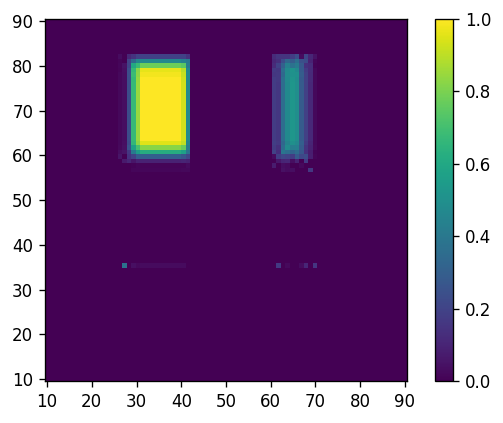

In [68]:
plt.figure(dpi=120)
plt.imshow(corr_mat_full, interpolation="none",
           extent=[flim[0]-df/2, flim[1]+df/2, flim[0]-df/2, flim[1]+df/2],
           origin="lower")
plt.xticks(np.arange(flim[0], flim[1]+1, 10))
plt.yticks(np.arange(flim[0], flim[1]+1, 10))
plt.colorbar()
plt.show()

In [9]:
def get_bin_array(df_sub_pop, idf):
    b_t0 = np.array(df_sub_pop["burst_t0"][idf])
    b_t1 = np.array(df_sub_pop["burst_t1"][idf])
    return binarize(b_t0, b_t1, tmax, dt)

@jit(nopython=True)
def binarize(event_t0, event_t1, tmax, dt):
    num = int(tmax / dt)
    b = np.zeros(num)
    for t0, t1 in zip(event_t0, event_t1):
        b[int(t0/dt):int(np.ceil(t1/dt))] = 1
    return b

In [232]:
from tqdm.notebook import tqdm
from numba import jit

cid = 1

df = 2
dt = 0.05
da = 0.2

flim = (10, 90)
alim = (0.1, 2)

tmax = 10

def discretize(x, xlim, dx):
    edges = np.arange(xlim[0]-dx/2, xlim[1]+dx, dx)
    nx = np.digitize(x, edges) - 1
    nid_exist = [i for i in range(len(edges)-1) if any(nx == i)]
    return nx, nid_exist, edges

In [233]:
from collections import defaultdict

bins = [{"amp": {"bins": [[], []], "nid": [[], []]},
          "f": {"bins": [[], []], "nid": [[], []]}} for _ in range(2)]

df_sub = df_burst[df_burst["cluster_id"] == cid]
df_set = [df_sub[df_sub["pop_type"] == 0],
          df_sub[df_sub["pop_type"] == 1]]

for tp in range(2):
    df_tp = df_set[tp]
    bins[tp]["f"]["bins"], bins[tp]["f"]["nid"], edges_f = discretize(df_tp["burst_f"], flim, df)
    bins[tp]["amp"]["bins"], bins[tp]["amp"]["nid"], edges_a = discretize(df_tp["burst_amp"], alim, da)

num_f = len(edges_f) - 1
num_a = len(edges_a) - 1

corr_mat = np.zeros([num_f, num_f, num_a, num_a])

for na0 in tqdm(bins[0]["amp"]["nid"]):
    for na1 in bins[1]["amp"]["nid"]:
        for nf0 in bins[0]["f"]["nid"]:
            id0 = (bins[0]["amp"]["bins"] == na0) & (bins[0]["f"]["bins"] == nf0)
            if np.sum(id0) == 0: continue
            x0 = get_bin_array(df_set[0], id0)
            for nf1 in bins[1]["f"]["nid"]:
                id1 = (bins[1]["amp"]["bins"] == na1) & (bins[1]["f"]["bins"] == nf1)
                if np.sum(id1) == 0: continue
                x1 = get_bin_array(df_set[1], id1)
                
                # p0 = np.sum(x0) / len(x0)
                # p1 = np.sum(x1) / len(x1)
                # p01 = (x0 @ x1) / len(x0)
                
                # corr_mat[nf0, nf1, na0, na1] = x0 @ x1 / np.sum(x0 + x1 > 0)
                corr_mat[nf0, nf1, na0, na1] = x0 @ x1 / len(x1)

  0%|          | 0/2 [00:00<?, ?it/s]

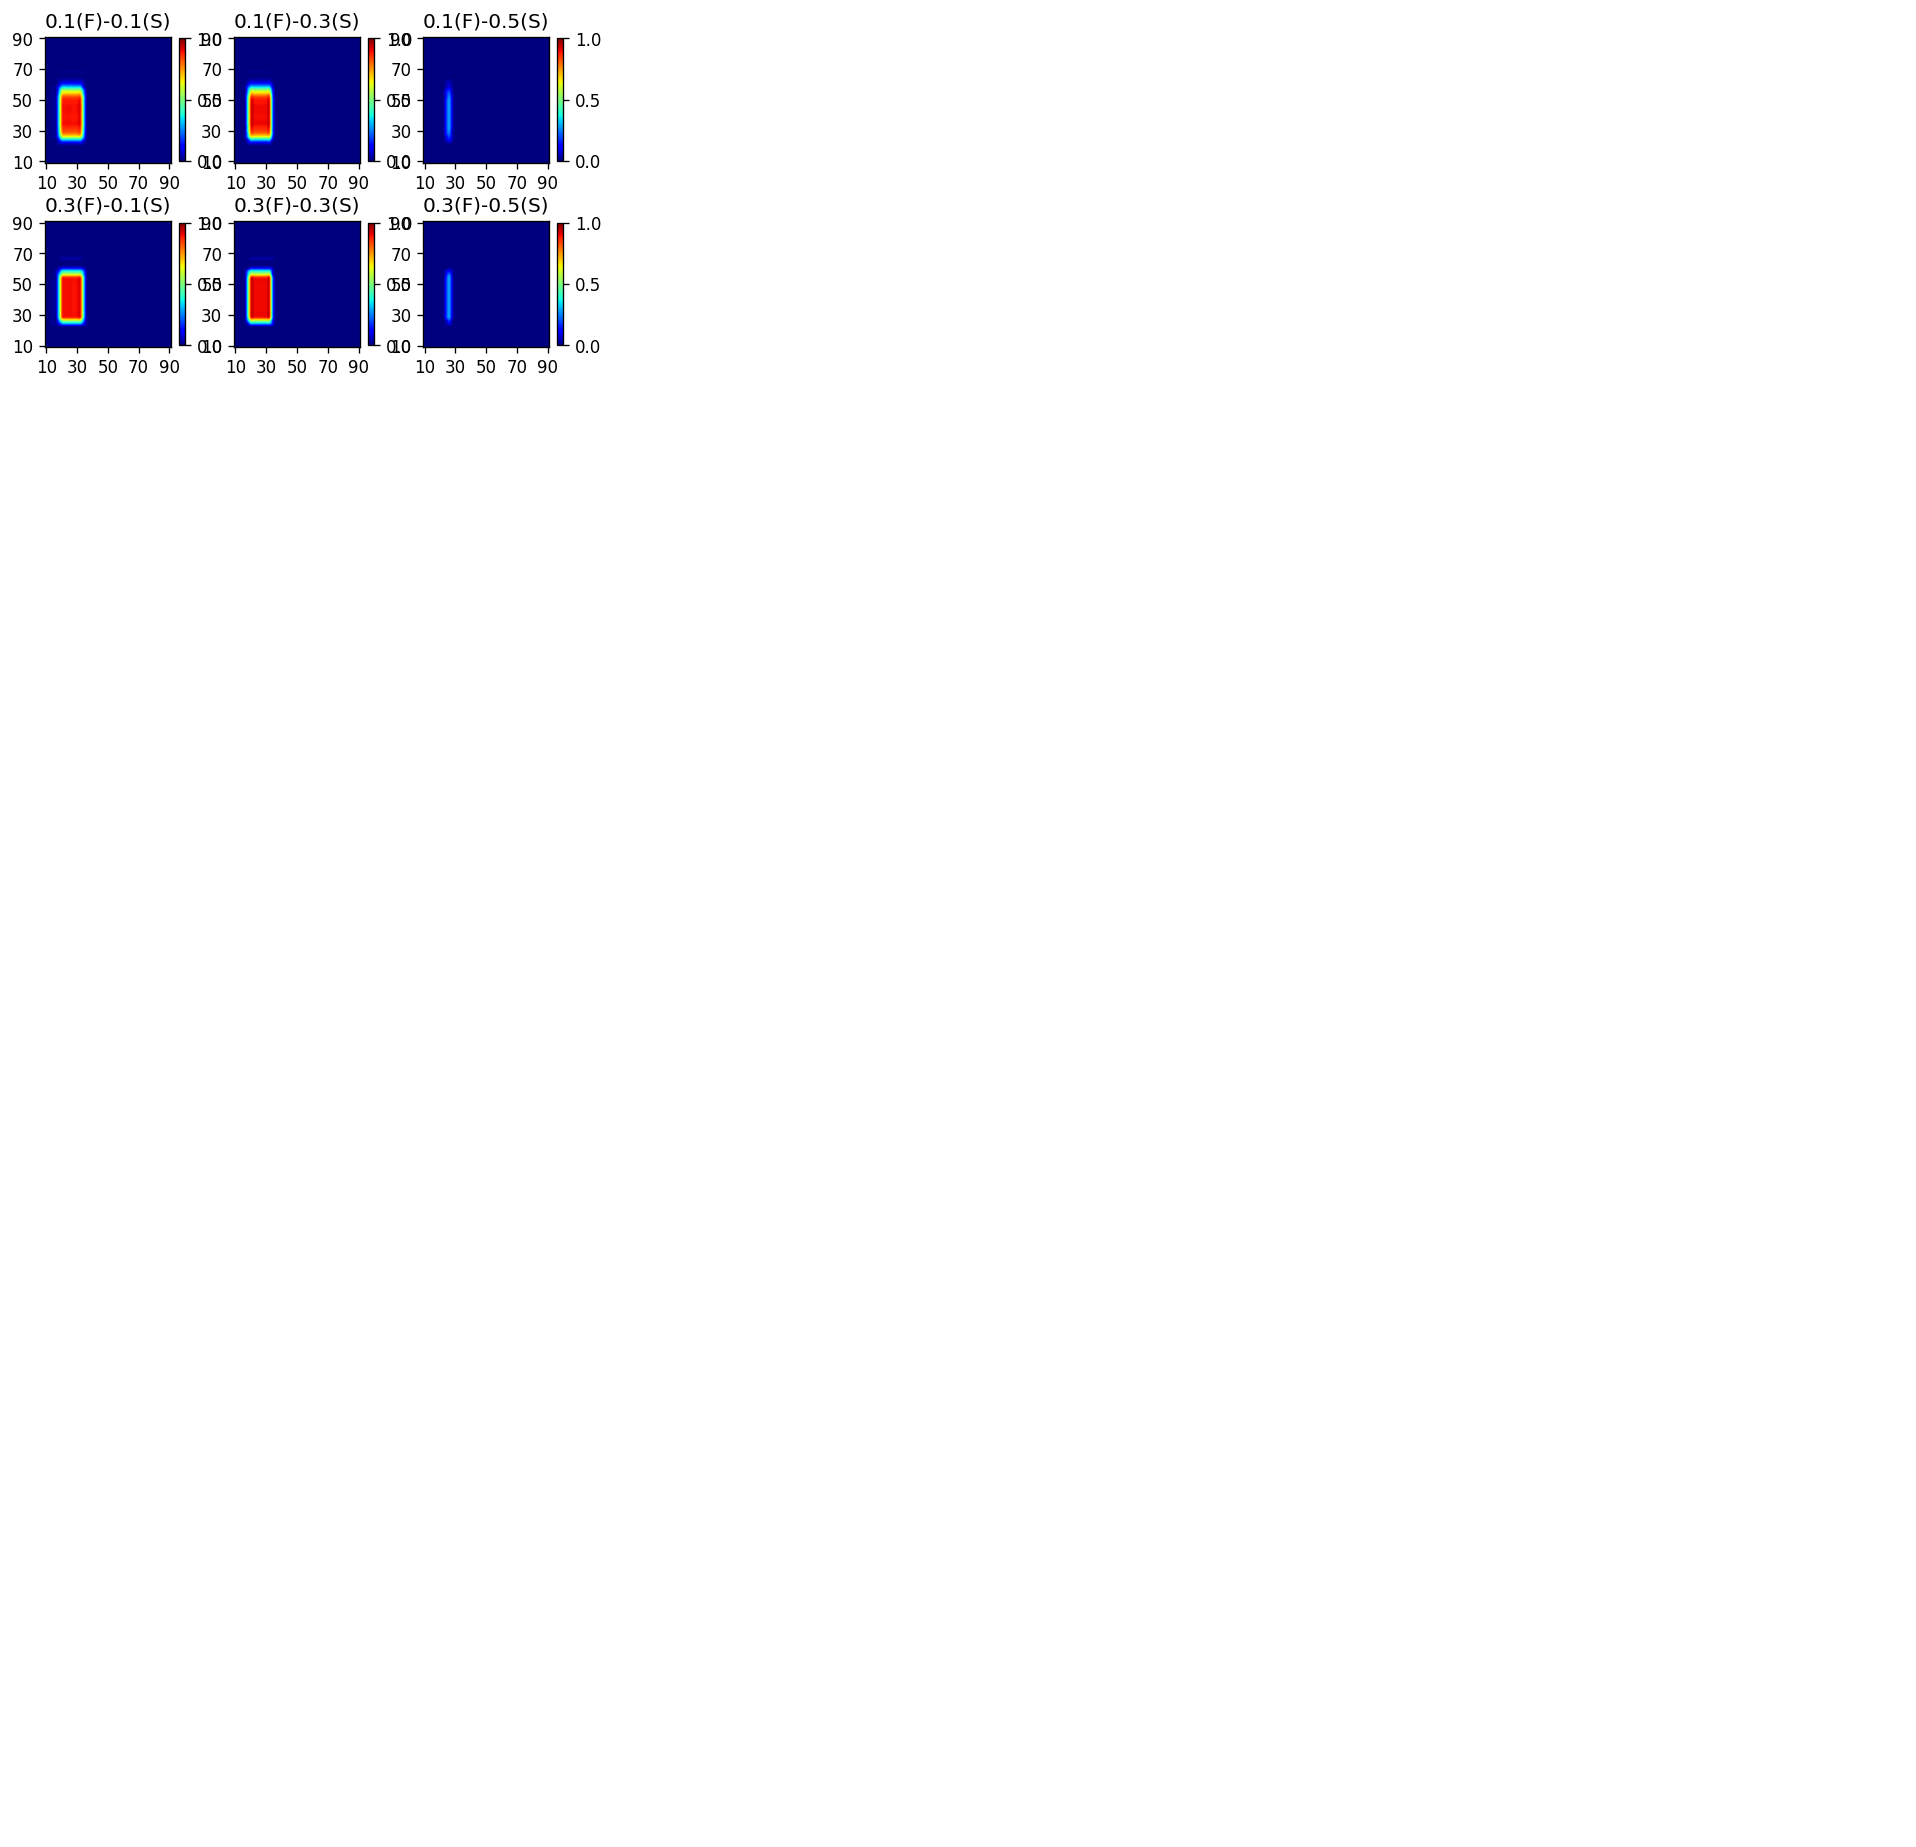

In [234]:
xa = (edges_a[1:] + edges_a[:-1])/2

fig, axs = plt.subplots(10, 10, dpi=120, figsize=(20, 20))
for na0 in range(num_a):
    for na1 in range(num_a):
        plt.axes(axs[na0][na1])
        if np.sum(corr_mat[:,:,na0,na1]) == 0:
            axs[na0][na1].axis("off")
            continue
        plt.imshow(corr_mat[:,:,na0,na1], interpolation="spline16",
                   extent=[flim[0]-df/2, flim[1]+df/2, flim[0]-df/2, flim[1]+df/2],
                   origin="lower", vmin=0, vmax=1, cmap="jet")
        plt.xticks(np.arange(flim[0], flim[1]+1, 20))
        plt.yticks(np.arange(flim[0], flim[1]+1, 20))
        plt.colorbar(shrink=0.8)
        plt.title("%.1f(F)-%.1f(S)"%(xa[na0], xa[na1]), fontsize=12)
        
plt.show()

In [276]:
cid = 10
pt  = 0

df_sub = df_burst.query("cluster_id == %d & pop_type == %d"%(cid, pt)).sort_values("burst_t0")
df_sub = df_sub.query("burst_f > 30 & burst_f < 34")

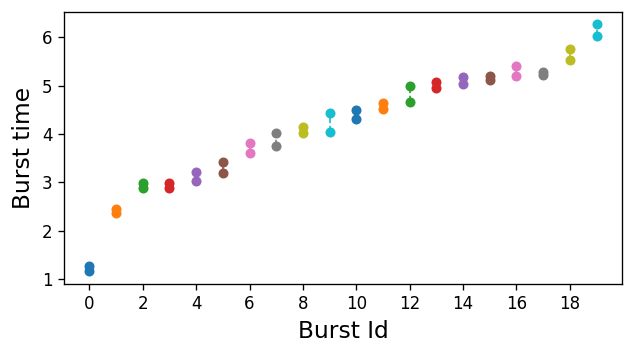

In [277]:
t0 = np.array(df_sub["burst_t0"])
t1 = np.array(df_sub["burst_t1"])

num = min([20, len(t0)])
plt.figure(dpi=120, figsize=(6, 3))
for i in range(num):
    plt.plot([i, i], [t0[i], t1[i]], '.--', ms=10, lw=1)
plt.xlabel("Burst Id", fontsize=14)
plt.ylabel("Burst time", fontsize=14)
plt.xticks(np.arange(0, num, 2))
plt.show()

In [163]:
@jit(nopython=True)
def binarize(event_t0, event_t1, tmax, dt):
    num = int(tmax / dt)
    b = np.zeros(num)
    for t0, t1 in zip(event_t0, event_t1):
        b[int(t0/dt):int(np.ceil(t1/dt))] = 1
    return b


def get_corr(df_burst, tmax=10, dt=0.01, **key_range):
    if len(np.unique(df_burst["cluster_id"])) > 1:
        raise ValueError("There are more than one clusters")
    
    # make query
    if len(key_range) == 0:
        raise ValueError("key_range empty")
    
    q = ""
    for k, v in key_range.items():
        if k not in ("burst_f", "burst_amp", "burst_duration"):
            raise ValueError("key %s is not in the target keys"%(k))
        if len(q) > 0: q += " & "
        q += "%s > %f & %s < %f"%(k, v[0], k, v[1])
    
    nlen = int(tmax / dt)
    
    bs = np.zeros([2, nlen], dtype=int)
    for tp in range(2):
        df_sub = df_burst[df_burst["pop_type"] == tp].query(q)
        t0, t1 = np.array(df_sub["burst_t0"]), np.array(df_sub["burst_t1"])
        bs[tp] = binarize(t0, t1, tmax, dt)
        if all(bs[tp]) == 0: return 0
    
    pxy = (np.sum(bs[0]) + np.sum(bs[1]) - np.sum(bs[0]+bs[1] > 0))/nlen
    
    return pxy


def get_edges(xlim, dx):
    return np.arange(xlim[0], xlim[1]+dx/2, dx)

In [164]:
cid = 10

df = 2
dt = 0.05
da = 0.2

flim = (10, 90)
alim = (0.1, 2)


df_sub = df_burst.query("cluster_id == %d"%(cid))

edges_a = get_edges(alim, da)
edges_f = get_edges(flim, df)
num_a = len(edges_a)-1
num_f = len(edges_f)-1

corr_mat = np.zeros([num_f, num_f, num_a, num_a])
for na0 in tqdm(range(num_a)):
    for na1 in range(num_a):
        for nf0 in range(num_f):
            for nf1 in range(num_f):
                corr_mat[nf0, nf1, na0, na1] = get_corr(df_sub, dt=dt, burst_f=flim, burst_amp=alim)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [161]:
df_sub

,burst_f,burst_amp,burst_t0,burst_t1,cluster_id,pop_type,burst_duration
96792,49.775072,0.350954,2.86,3.23,10.0,0,0.37
96793,50.050050,0.338497,5.92,6.18,10.0,0,0.26
96794,60.060060,0.348430,6.17,6.32,10.0,0,0.15
96795,44.750237,0.327154,1.59,1.85,10.0,0,0.26
96796,46.046046,0.336254,6.29,6.58,10.0,0,0.29
...,...,...,...,...,...,...,...
102387,52.420139,0.347589,5.55,5.88,10.0,0,0.33
102388,53.375477,0.353247,4.42,4.77,10.0,0,0.35
102389,45.045045,0.330018,7.95,8.21,10.0,0,0.26
102390,54.385197,0.323517,7.56,7.91,10.0,0,0.35


In [158]:
pxy = get_corr(df_sub, burst_f=(10, 90), burst_amp=(0, 3))
print(pxy)

0.899


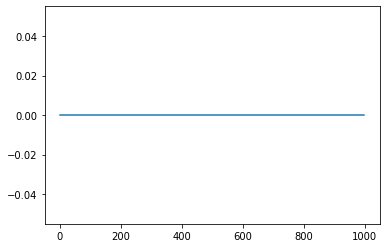

In [91]:
cond = get_corr(df_sub, 10, 0.01)

In [107]:
cond = df_sub["burst_f"].between(30, 40)

In [113]:
df_sub.query("")

TypeError: query() missing 1 required positional argument: 'expr'

In [108]:
cond

133673    False
133674    False
133675    False
133676    False
133677    False
          ...  
146215     True
146216    False
146217     True
146218     True
146219    False
Name: burst_f, Length: 12547, dtype: bool

In [92]:
df_sub[cond]

ValueError: Item wrong length 1000 instead of 12547.

In [89]:
df_sub["cluster_id"]

133673    14.0
133674    14.0
133675    14.0
133676    14.0
133677    14.0
          ... 
146215    14.0
146216    14.0
146217    14.0
146218    14.0
146219    14.0
Name: cluster_id, Length: 12547, dtype: float64

,burst_f,burst_amp,burst_t0,burst_t1,cluster_id,pop_type,burst_duration


,burst_f,burst_amp,burst_t0,burst_t1,cluster_id,pop_type,burst_duration


In [84]:
np.sum(cond)

1000

In [322]:
corr_mat.shape

(41, 41, 10, 10)

In [309]:
edges_a

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [293]:
nid_exist = [i for i in range(len(edges_a)) if any(na[i] == i)]

TypeError: 'numpy.bool_' object is not iterable

In [295]:
na[0] == 9

False

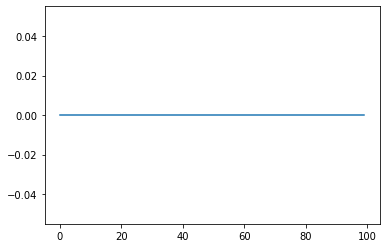

In [214]:
b = get_bin_array(df_set[0], 70)
plt.plot(b)

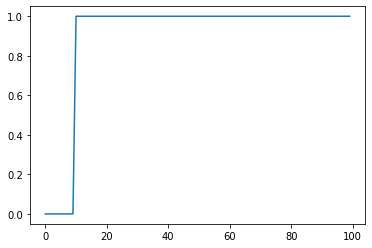

In [171]:
for i in range(12, 13):
    bx = get_bin_array(df_set[0], df*i)
    plt.plot(bx)

In [189]:
idf1 = ((df_set[0]["burst_f"] - frange[0] - df*12)/df).astype(int) == 0
nid_set = np.where(idf1)[0]

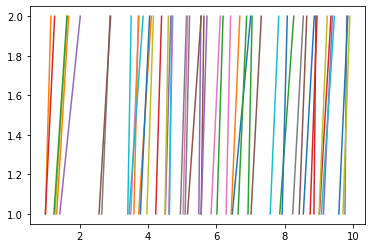

In [194]:
plt.figure()
for n in range(50):
    plt.plot([np.array(df_set[0]["burst_t0"])[nid_set[n]], np.array(df_set[0]["burst_t1"])[nid_set[n]]], [1, 2])

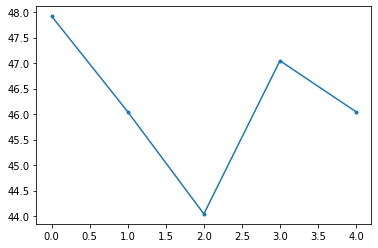

In [201]:
plt.figure()
plt.plot(np.array(df_set[0]["burst_f"])[nid_set[:5]], '.-')



In [175]:
len(df_set[0]["burst_f"])

6219

In [174]:
len(idf1)

6219

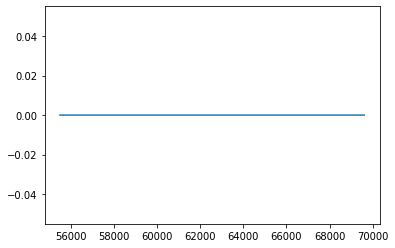

In [157]:
ftarget = df*4
idf1 = ((df_set[0]["burst_f"] - frange[0] - df*5)/df).astype(int) == 0
idf2 = ((df_set[0]["burst_f"] - frange[0] - df*7)/df).astype(int) == 0
plt.plot(idf1 & idf2)

In [145]:
idf1 = np.floor((df_set[0]["burst_f"] - frange[0] - df*4)/df).astype(int)
idf2 = np.floor((df_set[0]["burst_f"] - frange[0] - df*5)/df).astype(int)

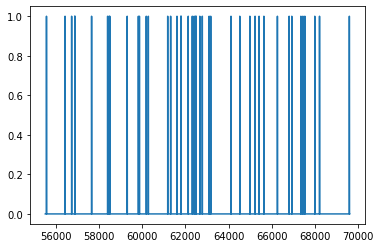

In [148]:
plt.plot(idf1 == idf2)

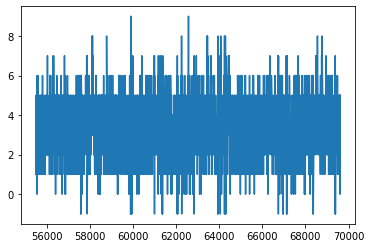

In [141]:
plt.plot(((df_set[0]["burst_f"] - frange[0] - df*4)/df).astype(int))

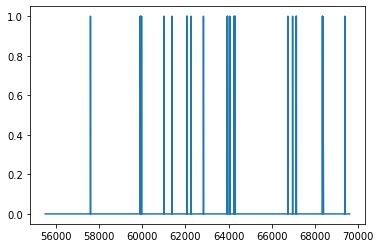

In [131]:
plt.plot(idf)

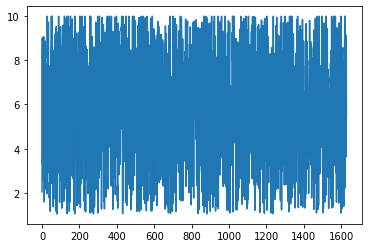

In [104]:
plt.plot(b_t1)

In [ ]:
idf = (df_set[1]["burst_f"] - frange[0] - df*i).astype(int) == 0

In [93]:
df_set[1]["burst_f"]

,burst_f,burst_amp,burst_t0,burst_t1,cluster_id,pop_type,burst_duration
55522,31.031031,0.656760,9.33,9.51,6.0,1,0.18
55523,32.032032,0.688589,8.75,9.31,6.0,1,0.56
55524,29.750041,0.489731,1.21,2.05,6.0,1,0.84
55525,31.185912,0.428679,4.21,4.91,6.0,1,0.70
55526,30.030030,0.563053,8.71,8.93,6.0,1,0.22
...,...,...,...,...,...,...,...
69632,33.553389,0.355593,2.85,3.21,6.0,1,0.36
69633,29.029029,0.373472,8.58,8.91,6.0,1,0.33
69634,29.029029,0.375890,5.30,5.44,6.0,1,0.14
69635,35.035035,0.371101,8.33,8.38,6.0,1,0.05


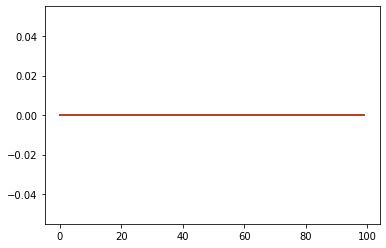

In [92]:
for n in range(num):
    bs = get_bin_array(df_set[1], df*n)
    plt.plot(bs)

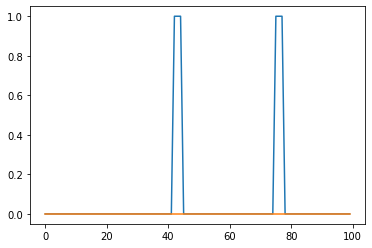

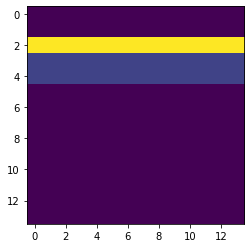

In [80]:
plt.imshow(corr_mat)

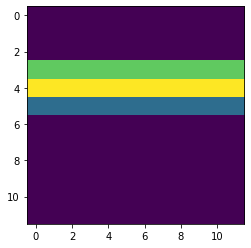

In [72]:
plt.imshow(corr_mat)

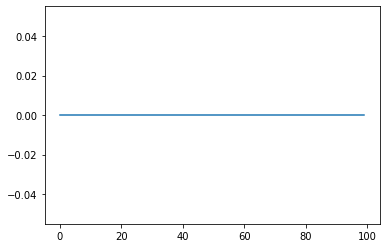

In [66]:
plt.plot(bs)

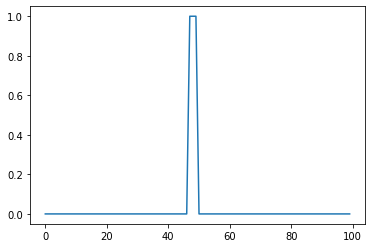

In [65]:
plt.plot(bf)

In [62]:
idf = (df_set[0]["burst_f"] - frange[0] - df*i).astype(int) == 0
b_t0 = np.array(df_set[0]["burst_t0"][idf])
b_t1 = np.array(df_set[0]["burst_t1"][idf])

NameError: name 'df_set' is not defined

In [ ]:
df

In [61]:
(df[0]["burst_f"] - frange[0] - df*i)

ValueError: operands could not be broadcast together with shapes (8920,) (0,) 

In [57]:
idf = (df[0]["burst_f"] - frange[0] - df*i).astype(int) == 0

ValueError: operands could not be broadcast together with shapes (8920,) (0,) 

In [52]:
@jit(nopython=True)
def binarize(event_t0, event_t1, tmax, dt):
    num = int(tmax / dt)
    b = np.zeros(num)
    for t0, t1 in zip(event_t0, event_t1):
        b[int(t0/dt):int(np.ceil(t1/dt))] = 1
    return b

In [53]:
bf = binarize(np.array(df[0]["burst_t0"]), np.array(df[0]["burst_t1"]), 10, dt)

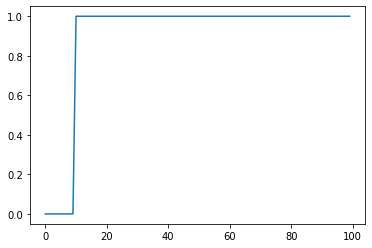

In [54]:
plt.plot(bf)

In [40]:
df_sub

,burst_f,burst_amp,burst_t0,burst_t1,cluster_id,pop_type,burst_duration
0,37.234631,0.285926,1.00,1.65,1.0,0,0.65
1,36.171108,0.295783,9.33,9.90,1.0,0,0.57
2,42.850323,0.247008,2.10,2.57,1.0,0,0.47
3,36.036036,0.257283,7.09,7.35,1.0,0,0.26
4,37.037037,0.272004,9.19,9.26,1.0,0,0.07
...,...,...,...,...,...,...,...
16212,30.764709,0.196562,9.78,9.99,1.0,1,0.21
16213,23.023023,0.196166,2.20,2.35,1.0,1,0.15
16214,23.023023,0.195730,5.08,5.19,1.0,1,0.11
16215,24.024024,0.193788,4.98,5.05,1.0,1,0.07


In [17]:
np.min(df_burst["burst_t0"])

1.0

In [18]:
np.max(df_burst["burst_t0"])

9.94